In [1]:
import sys
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
# Local
cwd = pathlib.Path().resolve()
src = cwd.parent
root = src.parent
sys.path.append(str(src))
sys.path.append(str(root))

from utils.watertopo import WaterTopo
from utils.simulation import Simulation
from utils.utils import count_parameters, mse_per_timestep

In [3]:
from models.CNN_3D import CNN_3D, create_sequence, train_and_validate, evaluate_model, train

In [4]:
#initialize GPU -  In case of windows use cuda instead of nps
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Is CUDA enabled?",torch.cuda.is_available())
print("Number of GPUs",torch.cuda.device_count())

Is CUDA enabled? False
Number of GPUs 0


In [5]:
model = CNN_3D(  input_channels=3,
                 hidden_size=64,
                 output_channels=1,
                 bias=True,
                 kernel_size=(3, 3, 3, 3), 
                 pool_kernel_size=1,
                 pool_stride=1, 
                 nonlinearity=F.relu
                 ).to(device)

print(f"CNN --> num. trainable parameters:{count_parameters(model):8d}")


CNN --> num. trainable parameters:  338881


In [ ]:
# Uncomment to train the model, otherwise load the best parameters below
training = True

if training:

    model, train_losses, val_losses, best_val_loss, time = train(model,
                                                      device=device,
                                                      root=root,
                                                      model_name = 'CNN/SpatCNN',
                                                      channels=2,
                                                      T=3,
                                                      H=1,
                                                      sim_amount=2,
                                                      training_size=0.8,
                                                      use_augmented_data=False,
                                                      batch_size=10,
                                                      num_epochs=20,
                                                      lr=0.005,
                                                      criterion=nn.MSELoss(),
                                                      optimizer=optim.AdamW,
                                                      )
    

shape of X:  (186, 3, 2, 64, 64)
shape of Y:  (186, 1, 1, 64, 64)
starting training
Epoch 1/20 Train Loss: 0.2164, Validation Loss: 0.0342 Best Validation Loss: 0.0342
Epoch 2/20 Train Loss: 0.0209, Validation Loss: 0.0157 Best Validation Loss: 0.0157
Epoch 3/20 Train Loss: 0.0122, Validation Loss: 0.0068 Best Validation Loss: 0.0068
Epoch 4/20 Train Loss: 0.0046, Validation Loss: 0.0020 Best Validation Loss: 0.0020
Epoch 5/20 Train Loss: 0.0035, Validation Loss: 0.0018 Best Validation Loss: 0.0018
Epoch 6/20 Train Loss: 0.0027, Validation Loss: 0.0014 Best Validation Loss: 0.0014
Epoch 7/20 Train Loss: 0.0026, Validation Loss: 0.0011 Best Validation Loss: 0.0011
Epoch 8/20 Train Loss: 0.0024, Validation Loss: 0.0010 Best Validation Loss: 0.0010
Epoch 9/20 Train Loss: 0.0026, Validation Loss: 0.0015 Best Validation Loss: 0.0010
Epoch 10/20 Train Loss: 0.0024, Validation Loss: 0.0012 Best Validation Loss: 0.0010
Epoch 11/20 Train Loss: 0.0027, Validation Loss: 0.0021 Best Validation Los

In [7]:
# # Plot validation loss
# fig, ax = plt.subplots(figsize=(20, 5))
# ax.plot(train_losses, label='Training Loss')
# ax.plot(val_losses, label='Validation Loss')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Loss')
# ax.set_title('Training and validation losses - CNN')
# ax.legend()

In [51]:
# This cell saves the averaged MSE for each timestep for 20 test simulations
model.eval()
model.load_state_dict(torch.load(str(src)+"/results/trained_models/cnn/SpatCNN"))

grid_size = 64
channels = 2
sim_length = 97
timesteps = 3

# Let's do a crude Monte Carlo with a single model, calculating the loss after each timestep
sims = WaterTopo.load_simulations(str(root)+"/data/normalized_data/test1/", 2, grid_size, use_augmented_data=True)
mse = np.zeros(97)

for sim in sims:

   inputs = np.zeros((1, timesteps, channels, grid_size, grid_size))
   targets = sim.wd


   # Select the time step where you want to start
   id = 0

   inputs[0, :, 0, :, :] = sim.topography
   inputs[0, 0, :, :, :] = sim.return_timestep(id)
   inputs[0, 1, :,  :, :] = sim.return_timestep(id)
   inputs[0, 2, :, :, :] = sim.return_timestep(id)
   
    
    
    
   
   inputs = torch.tensor(inputs, dtype=torch.float32)
   
   targets = torch.tensor(targets, dtype=torch.float32)
   #targets[0,:, :,:] = inputs[0,1,:,:]

   outputs = torch.zeros(targets.shape)
   outputs[:3, :,:] = inputs[0,:,1,:,:]
   

   for t in range(3, sim_length):
      outputs[t,:,:] = model(inputs.to(device)).detach()
      #print(outputs.shape)
      #print(inputs.shape)
      #print(inputs[0,:,0,:,:].size())
      #print(outputs[t,:,:].size())  
      #print(t) 
      torch.cat((inputs[0,2,0,:,:], outputs[t,:,:]))

   mse += mse_per_timestep(targets, outputs)

mse = mse / len(sims)

np.savetxt(str(src)+"/results/error_accumulation/CNN_3D", mse)


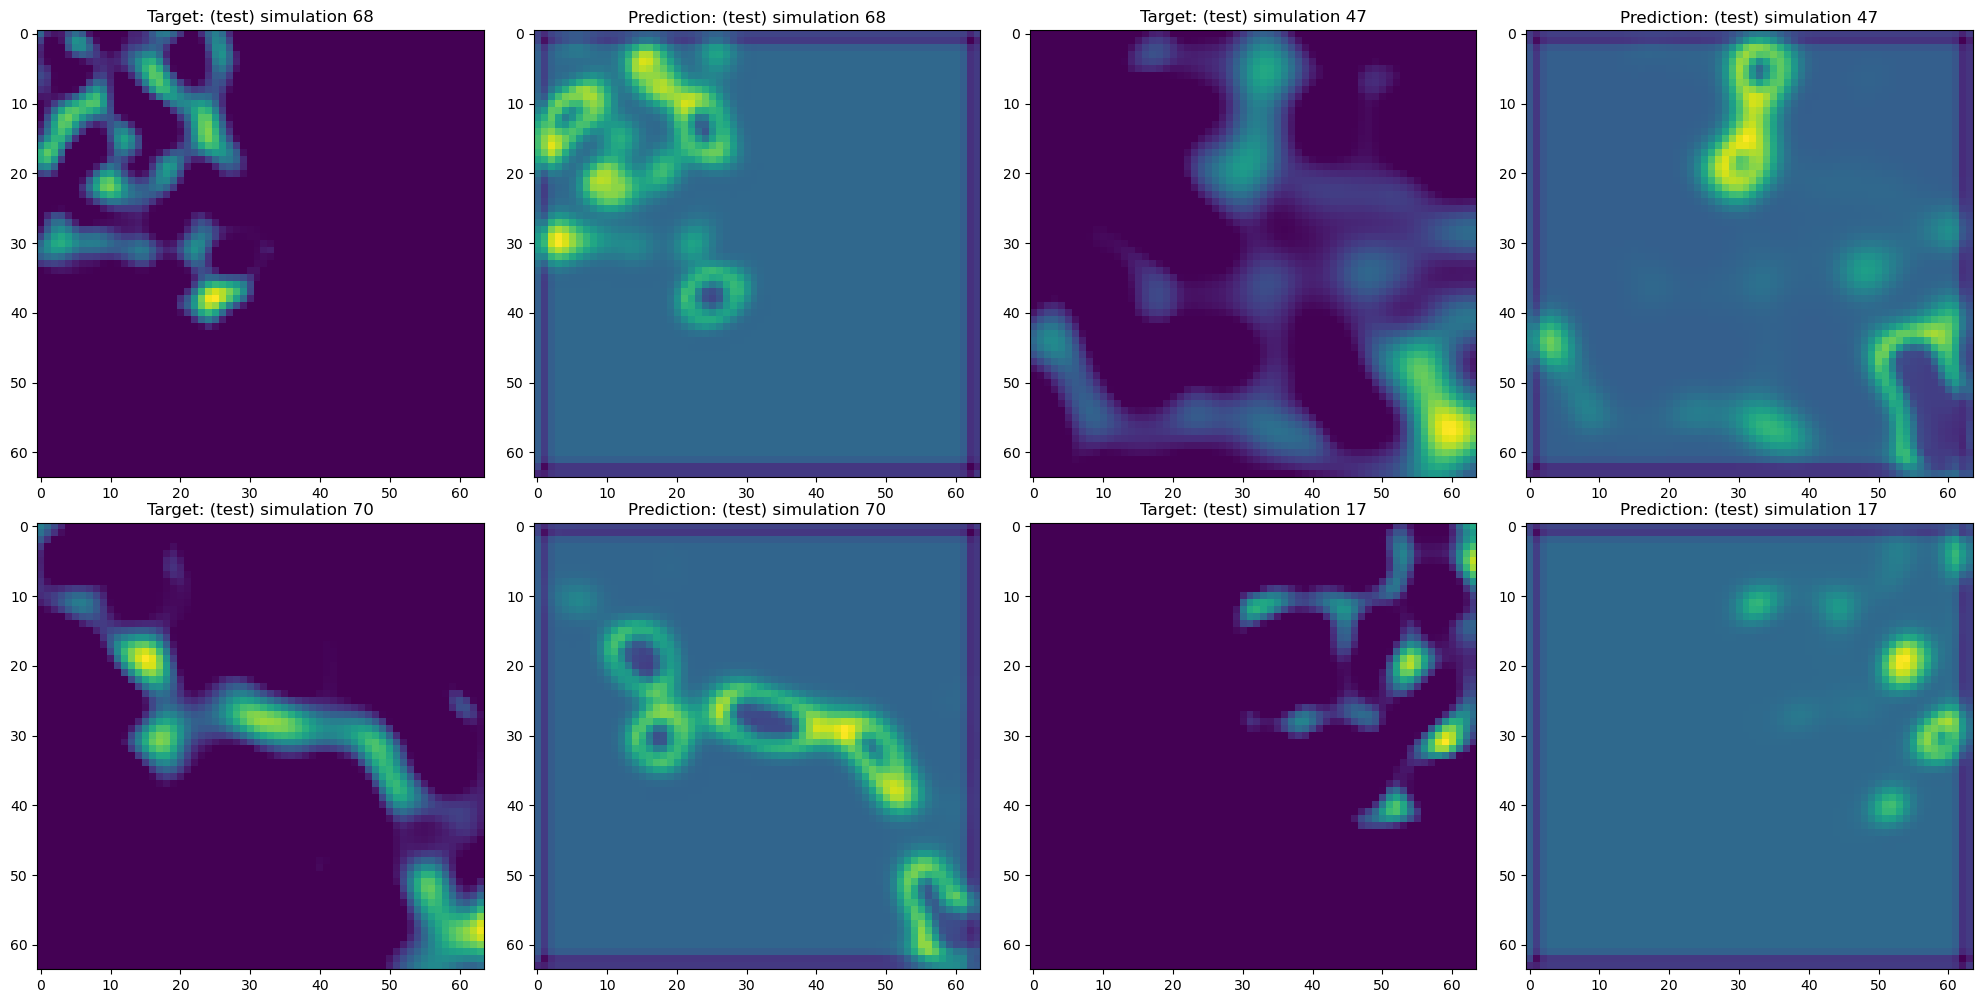

In [54]:
# Let's try the model!
model.eval()

grid_size = 64
channels = 2

f,axs = plt.subplots(2, 4, figsize=(20,10))
axs = axs.reshape(-1)

for i in range(0, len(axs), 2):
  with torch.no_grad():
      # Randomly select a simulation
      random_index = random.randint(0, 80)
      sim = WaterTopo.load_simulations(str(root)+"/data/normalized_data/tra_val/", 
                                       1, 
                                       grid_size)[0]

      
      inputs = np.zeros((1, timesteps, channels, grid_size, grid_size))
      #targets = sim.wd


      # Select the time step where you want to start
      id = random.randint(3, 95)

      inputs[0, :, 0, :, :] = sim.topography
      inputs[0, 0, :, :, :] = sim.return_timestep(id)
      inputs[0, 1, :,  :, :] = sim.return_timestep(id)
      inputs[0, 2, :, :, :] = sim.return_timestep(id)

      targets = np.zeros((1, grid_size, grid_size))

     

    
    
      targets[0, :,:]  = sim.return_timestep(id+1)

      # Predict
      inputs = torch.tensor(inputs, dtype=torch.float32).to(device)
      inputs.cpu()
      prediction = model(inputs).cpu()

      # Plotting inputs (time series)
      axs[i].imshow(targets[0,:,:])
      axs[i+1].imshow(prediction[0,0,0,:,:])

      axs[i].set_title(f"Target: (test) simulation {random_index}")
      axs[i+1].set_title(f"Prediction: (test) simulation {random_index}")

f.tight_layout()


In [ ]:
animation_create(savepath,X,Y,Z,wd,N,fps = 10, color_dem=cm.gist_earth, mask_threshold=0)




